## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Importing Necessary Libraries

In [148]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import gzip
import io
import calendar

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, probplot

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data Staging

In [149]:
# Unzipping data
def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

# unzip_data('DataUnzipped/im.db.zip')


In [150]:
# # Connect to sqlite3
path = './DataUnzipped/im.db'
conn = sqlite3.connect(path)
query = 'SELECT * FROM movie_basics'
# Connect to SQLite database
im = pd.read_sql_query(query, conn)
im_df = pd.DataFrame(im)

# im_df.head()

In [151]:
#loading the csv files
bom = pd.read_csv('DataUnzipped/bom.movie_gross.csv')
# bom.head()

In [152]:
tmdb_movies = pd.read_csv('DataUnzipped/tmdb.movies.csv', index_col = 0)
# tmdb_movies.head()

In [153]:
tn_movies_b = pd.read_csv('DataUnzipped/tn.movie_budgets.csv', index_col = 0)
# tn_movies_b.head()

# Data Cleaning

#### Data Cleaning Procedure:
- Dropping columns
- Removing Duplicates
- Merging DataFrames
- Dropping Columns after merge
- Dropping null values
- Dropping duplicates after merge

In [154]:
# Drop Year
bom = bom.drop('year', axis=1)

In [155]:
# Drop original_title, start_year, and movie_id columns
columns_dropping = ['original_title', 'start_year', 'movie_id']
im_df = im_df.drop(columns=columns_dropping)

In [156]:
# Unnamed, genre_ids,original_title, id
column_dropping = ['genre_ids', 'id', 'original_title']
tmdb_movies = tmdb_movies.drop(columns=column_dropping)

In [157]:
tn_movies_b['movie'].nunique()

5698

In [158]:
# Identify duplicate movies in the 'movie' column
duplicate_movies = tn_movies_b[tn_movies_b['movie'].duplicated()]

# duplicate_movies.head()


In [159]:
# Group by the 'movie' column and count occurrences, then filter for duplicates
duplicate_movie_counts = tn_movies_b['movie'].value_counts()
duplicate_movie_counts = duplicate_movie_counts[duplicate_movie_counts > 1]

# duplicate_movie_counts

In [160]:
# Filter rows where the movie name is 'Godzilla'
godzilla_movies = tn_movies_b[tn_movies_b['movie'] == 'Halloween']

# godzilla_movies

In [161]:
# Perform an inner join on the title columns
merged_df = pd.merge(bom, im_df, left_on='title', right_on='primary_title', how='inner')
merged_df2 = pd.merge(merged_df, tmdb_movies, left_on='title', right_on='title', how='inner')
merged_df3 = pd.merge(merged_df2, tn_movies_b, left_on='title', right_on='movie', how='inner')

# Display the first few rows of the merged DataFrame
# merged_df3.head()

In [162]:
merged_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2097 non-null   object 
 1   studio             2097 non-null   object 
 2   domestic_gross_x   2096 non-null   float64
 3   foreign_gross      1751 non-null   object 
 4   primary_title      2097 non-null   object 
 5   runtime_minutes    1959 non-null   float64
 6   genres             2057 non-null   object 
 7   original_language  2097 non-null   object 
 8   popularity         2097 non-null   float64
 9   release_date_x     2097 non-null   object 
 10  vote_average       2097 non-null   float64
 11  vote_count         2097 non-null   int64  
 12  release_date_y     2097 non-null   object 
 13  movie              2097 non-null   object 
 14  production_budget  2097 non-null   object 
 15  domestic_gross_y   2097 non-null   object 
 16  worldwide_gross    2097 

In [163]:
column_dropping = ['primary_title', 'foreign_gross', 'original_language', 'release_date_y', 'domestic_gross_x']
merged_df3 = merged_df3.drop(columns = column_dropping)
# merged_df3.head()

In [164]:
# Drop rows with any missing values

merged_df3.dropna(inplace=True)


In [165]:
# Droping the Duplicates
merged_df3.drop_duplicates(inplace=True)

In [166]:
merged_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1764 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1764 non-null   object 
 1   studio             1764 non-null   object 
 2   runtime_minutes    1764 non-null   float64
 3   genres             1764 non-null   object 
 4   popularity         1764 non-null   float64
 5   release_date_x     1764 non-null   object 
 6   vote_average       1764 non-null   float64
 7   vote_count         1764 non-null   int64  
 8   movie              1764 non-null   object 
 9   production_budget  1764 non-null   object 
 10  domestic_gross_y   1764 non-null   object 
 11  worldwide_gross    1764 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 179.2+ KB


# Statistical Analysis

In [167]:
df = merged_df3.copy()

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1764 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1764 non-null   object 
 1   studio             1764 non-null   object 
 2   runtime_minutes    1764 non-null   float64
 3   genres             1764 non-null   object 
 4   popularity         1764 non-null   float64
 5   release_date_x     1764 non-null   object 
 6   vote_average       1764 non-null   float64
 7   vote_count         1764 non-null   int64  
 8   movie              1764 non-null   object 
 9   production_budget  1764 non-null   object 
 10  domestic_gross_y   1764 non-null   object 
 11  worldwide_gross    1764 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 179.2+ KB


In [169]:
# Removing currency symbols and commas, then converting to numeric
df['production_budget'] = df['production_budget'].replace('[\$,]', '', regex=True).astype(float)
df['domestic_gross_y'] = df['domestic_gross_y'].replace('[\$,]', '', regex=True).astype(float)
df['worldwide_gross'] = df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)

In [170]:
df.describe()

,runtime_minutes,popularity,vote_average,vote_count,production_budget,domestic_gross_y,worldwide_gross
count,1764.000000,1764.000000,1764.000000,1764.000000,1.764000e+03,1.764000e+03,1.764000e+03
mean,102.873583,11.742131,6.266893,1919.866213,4.347379e+07,5.758016e+07,1.412417e+08
std,24.092100,8.125587,1.100051,2758.124577,5.410906e+07,8.443615e+07,2.274563e+08
min,3.000000,0.600000,0.000000,1.000000,5.000000e+04,0.000000e+00,0.000000e+00
25%,91.000000,7.516000,5.800000,231.000000,8.500000e+06,4.463292e+06,1.431204e+07
50%,102.000000,10.308000,6.300000,920.000000,2.500000e+07,3.097192e+07,6.032721e+07
75%,116.000000,14.802750,6.900000,2282.250000,5.040000e+07,7.139912e+07,1.591656e+08
max,192.000000,80.773000,10.000000,22186.000000,4.106000e+08,7.000596e+08,2.048134e+09


In [171]:
df.corr(numeric_only=True)

,runtime_minutes,popularity,vote_average,vote_count,production_budget,domestic_gross_y,worldwide_gross
runtime_minutes,1.000000,0.228878,0.199348,0.239648,0.218275,0.158339,0.187787
popularity,0.228878,1.000000,0.293032,0.681098,0.517353,0.484146,0.522407
vote_average,0.199348,0.293032,1.000000,0.340374,0.070867,0.154044,0.158699
vote_count,0.239648,0.681098,0.340374,1.000000,0.560976,0.685793,0.702576
production_budget,0.218275,0.517353,0.070867,0.560976,1.000000,0.692666,0.767890
domestic_gross_y,0.158339,0.484146,0.154044,0.685793,0.692666,1.000000,0.944452
worldwide_gross,0.187787,0.522407,0.158699,0.702576,0.767890,0.944452,1.000000


In [172]:
# Set figure size to make the plot larger
plt.figure(figsize=(10, 8))

# Plotting the correlation heatmap
# dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
# plt.show()

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [173]:
df_numeric = df.select_dtypes(include = ['number'])
df_numeric.corr()

,runtime_minutes,popularity,vote_average,vote_count,production_budget,domestic_gross_y,worldwide_gross
runtime_minutes,1.000000,0.228878,0.199348,0.239648,0.218275,0.158339,0.187787
popularity,0.228878,1.000000,0.293032,0.681098,0.517353,0.484146,0.522407
vote_average,0.199348,0.293032,1.000000,0.340374,0.070867,0.154044,0.158699
vote_count,0.239648,0.681098,0.340374,1.000000,0.560976,0.685793,0.702576
production_budget,0.218275,0.517353,0.070867,0.560976,1.000000,0.692666,0.767890
domestic_gross_y,0.158339,0.484146,0.154044,0.685793,0.692666,1.000000,0.944452
worldwide_gross,0.187787,0.522407,0.158699,0.702576,0.767890,0.944452,1.000000


In [174]:
plt.figure(figsize = (10,6))

# sns.regplot(data=df,x='domestic_gross_y',y='worldwide_gross')
# plt.title('ScatterPlot on Correlation')

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [175]:
# Scatter plot for the budget against worlwide gross
plt.figure(figsize=(10,8))
# sns.regplot(data=df,x='production_budget',y='worldwide_gross')
# plt.grid()

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

# EDA

In [176]:
# df['genres'].unique()

In [177]:
# Split genres by comma, stack into a single column, and count each genre
genre_counts = df['genres'].str.split(',').explode().value_counts()

# Display the result
# print(genre_counts)


In [178]:
listofgenre = df.loc[:,['genres']]

In [179]:
gen = listofgenre.stack().to_list()

In [180]:
from collections import defaultdict

# Step 1: Initialize a dictionary to hold genre counts
genre_counts = defaultdict(int)

# Step 2: Loop through each genre string, split it, and count each genre
for genres in gen:
    # Split the genres and strip any extra whitespace
    individual_genres = genres.split(',')
    for genre in individual_genres:
        genre = genre.strip()  # Ensure no leading/trailing whitespace
        genre_counts[genre] += 1

# Convert the defaultdict to a regular dictionary (optional)
genre_counts = dict(genre_counts)

# Display the result
print(genre_counts)

{'Adventure': 336, 'Animation': 100, 'Comedy': 508, 'Action': 434, 'Sci-Fi': 121, 'Drama': 897, 'Fantasy': 120, 'Family': 88, 'Thriller': 308, 'History': 64, 'Romance': 218, 'Horror': 201, 'Mystery': 132, 'Western': 8, 'Biography': 154, 'Documentary': 126, 'Crime': 230, 'Sport': 41, 'War': 15, 'Music': 49, 'Musical': 5, 'News': 2}


In [181]:
# # Convert dictionary keys and values to lists for plotting
# genres = list(genre_counts.keys())
# counts = list(genre_counts.values())

# # Bar plot for genre counts
# plt.figure(figsize=(12, 6))
# # plt.bar(genres, counts, color='blue')
# plt.xlabel('Number of Movies')
# plt.ylabel('Genres')
# plt.title('Distribution of Movie Genres')
# plt.xticks(rotation=45)
# # plt.show()

In [182]:
# Initialize a dictionary to hold lists of titles for each genre
genre_movies = defaultdict(list)

# Loop through each row in the DataFrame
for _, row in df.iterrows():
    # Split the genres in the current row
    row_genres = row["genres"].split(',')
    for genre in row_genres:
        genre = genre.strip()  # Remove any extra whitespace
        # Check if the genre exists in genre_counts and add the title to genre_movies
        if genre in genre_counts:
            genre_movies[genre].append(row["title"])

# Convert the defaultdict to a regular dictionary (optional)
genre_movies = dict(genre_movies)

# Display the result
# print(genre_movies)

In [183]:
genre_movies.keys()

dict_keys(['Adventure', 'Animation', 'Comedy', 'Action', 'Sci-Fi', 'Drama', 'Fantasy', 'Family', 'Thriller', 'History', 'Romance', 'Horror', 'Mystery', 'Western', 'Biography', 'Documentary', 'Crime', 'Sport', 'War', 'Music', 'Musical', 'News'])

In [184]:
genrate = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    # getting avg
    numeric_values = [float(value) for value in moviedata['vote_average']]
    avg = sum(numeric_values)/len(numeric_values)
    
    genrate.append({key:avg})
# genrate

In [185]:
# Ensure columns are NumPy arrays and calculate ROI
roi = df['worldwide_gross'].values / df['production_budget'].values

# Convert the result back to a pandas Series and add to DataFrame
df['roi'] = pd.Series(roi, index=df.index)


In [186]:
genroi = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    # getting avg
    numeric_values = [float(value) for value in moviedata['roi']]
    avg = sum(numeric_values)/len(numeric_values)
    
    genroi.append({key:avg})

# genroi

In [187]:
genrevenue = []
for key, value in genre_movies.items():
    movies = genre_movies.get(key, [])
    movies = pd.Series(movies)
    moviedata = df[df['title'].isin(movies)]
    
    # Calculate the sum of worldwide_gross
    total_gross = moviedata['worldwide_gross'].sum()
    
    # Calculate the average, avoiding division by zero
    avg = total_gross / len(moviedata['worldwide_gross']) 
    
    genrevenue.append({key: avg})
# genrevenue

In [188]:
# Initialize a dictionary to combine values
combined_dict = {}

# Combine the first list of dictionaries
for entry in genrevenue:
    for key, value in entry.items():
        combined_dict[key] = [value]  # Start a new list for each genre

# Append the values from the second list of dictionaries
for entry in genrate:
    for key, value in entry.items():
        if key in combined_dict:
            combined_dict[key].append(value)  # Append to existing list

# Append the values from the third list of dictionaries
for entry in genroi:
    for key, value in entry.items():
        if key in combined_dict:
            combined_dict[key].append(value)  # Append to existing list

# Convert the combined dictionary into a DataFrame
combined_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in combined_dict.items()]))

# Transpose the DataFrame
transposed_df = combined_df.T

# Change column names
transposed_df.columns = ['genre_avg_gross', 'gen_avg_rating', 'gen_avg_roi']  # Assign new column names

# Optionally, reset the index to make the genre names a column
transposed_df.reset_index(inplace=True)

# Rename the index column for clarity
transposed_df.rename(columns={'index': 'Genre'}, inplace=True)

# Display the transposed DataFrame
# transposed_df.to_csv('./genreAnalysis.csv')

# To be used in data visualization
# transposed_df

In [189]:
# # Plotting
# plt.figure(figsize=(12, 6))
# plt.bar(transposed_df['Genre'], transposed_df['gen_avg_roi'], color='blue')
# plt.title('Average ROI by Genre')
# plt.xlabel('Genre')
# plt.ylabel('Average ROI')
# plt.xticks(rotation=45)
# plt.grid(axis='y')
# # plt.show()

Text(0.5, 1.0, 'Boxplot of the Production Budget')

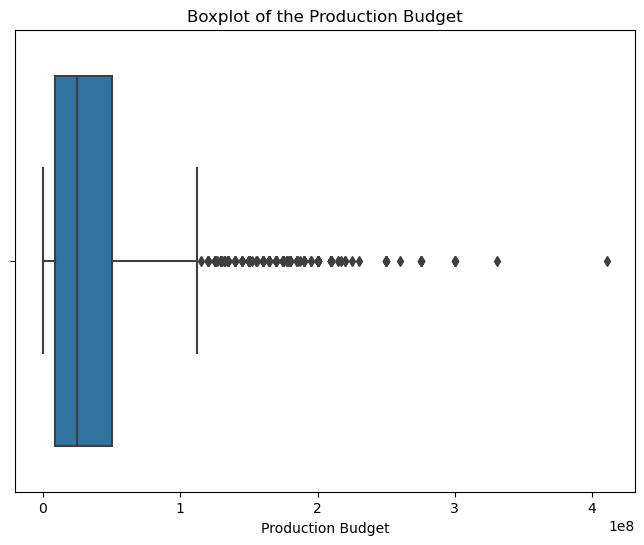

In [190]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='production_budget')
plt.xlabel('Production Budget')
plt.title('Boxplot of the Production Budget')
# plt.show()

Text(0.5, 1.0, 'Distribution of the Runtime Minutes')

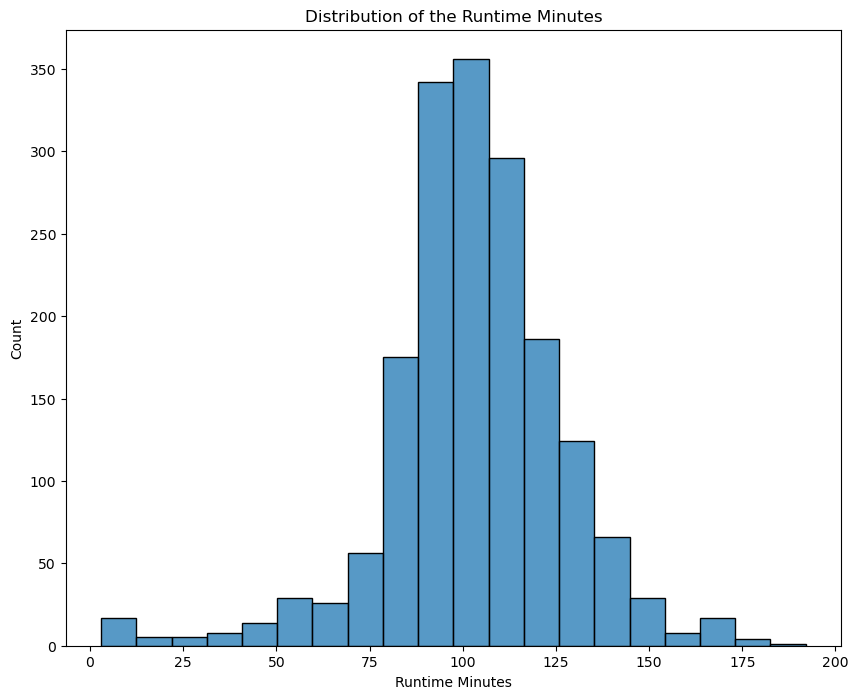

In [191]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='runtime_minutes',bins=20)
plt.xlabel('Runtime Minutes')
plt.title('Distribution of the Runtime Minutes')

Text(0.5, 1.0, 'Distribution of the Worldwide gross')

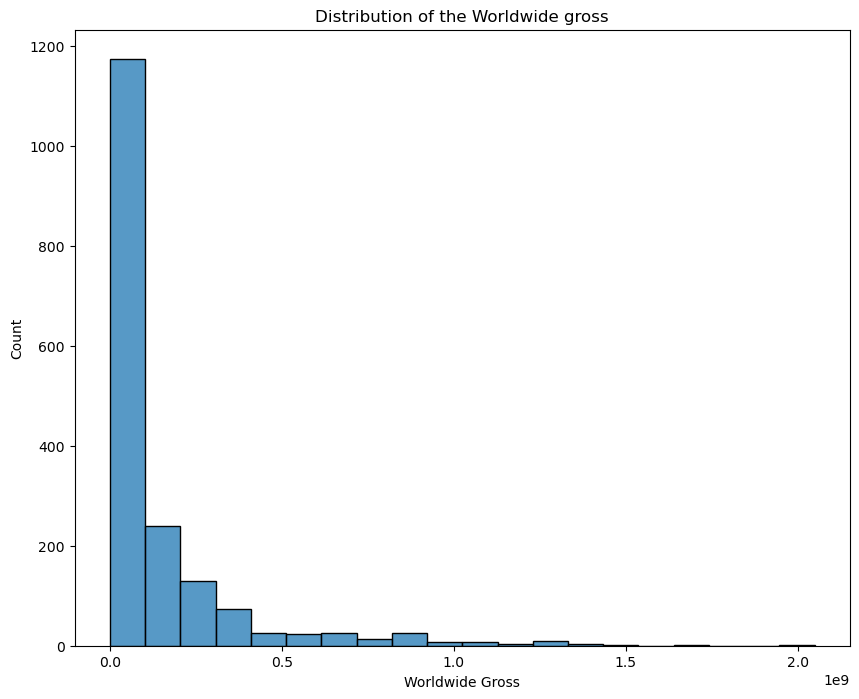

In [192]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='worldwide_gross',bins=20)
plt.xlabel('Worldwide Gross')
plt.title('Distribution of the Worldwide gross')

In [193]:
# Created a year variable from the release date 
df['year'] = pd.to_datetime(df['release_date_x']).dt.year

In [194]:
# budgets and revenue ,vote_count average rating
filter_data = df[df['year']>=2010]

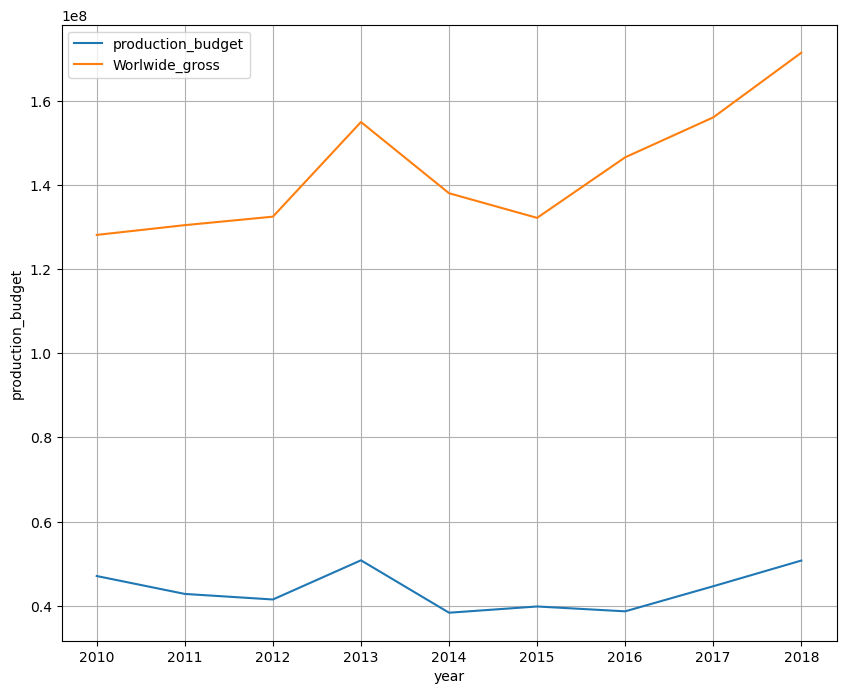

In [195]:
plt.figure(figsize=(10,8))
sns.lineplot(data=filter_data,x='year',y='production_budget',label='production_budget',ci=None)
sns.lineplot(data=filter_data,x='year',y='worldwide_gross',label='Worlwide_gross',ci=None)
# sns.lineplot()
plt.grid()

In [196]:
df['release_date_x'] = pd.to_datetime(df['release_date_x'])
df['month'] = df['release_date_x'].dt.month

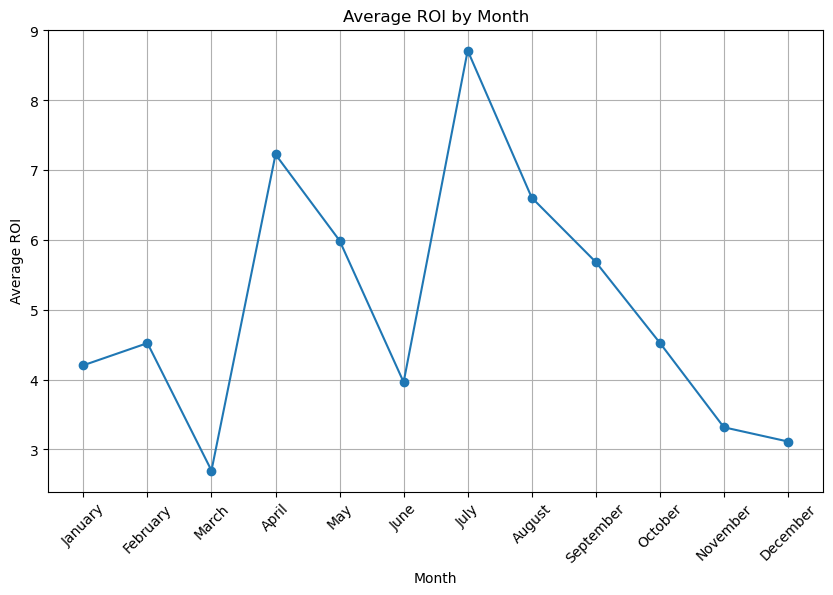

In [197]:
# Aggregate ROI by month (e.g., average ROI for each month)
monthly_roi = df.groupby('month')['roi'].mean().reset_index()

# Create a mapping of month numbers to month names
month_names = [calendar.month_name[i] for i in range(1, 13)]  # Full month names from January to December

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_roi['month'], monthly_roi['roi'], marker='o')
plt.title('Average ROI by Month')
plt.xlabel('Month')
plt.ylabel('Average ROI')
plt.xticks(monthly_roi['month'], month_names[:len(monthly_roi)], rotation=45)  # Change numbers to month names
plt.grid()
plt.show()

# Linear Regression

In [224]:
rstyle_model = smf.ols(formula="worldwide_gross ~ popularity + vote_average + vote_count + production_budget", data=df)
rstyle_results = rstyle_model.fit()

In [225]:
print(rstyle_results.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     1023.
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:54:36   Log-Likelihood:                -35386.
No. Observations:                1764   AIC:                         7.078e+04
Df Residuals:                    1759   BIC:                         7.081e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          5.029e+06   1.82e+0

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1764 entries, 0 to 2095
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              1764 non-null   object        
 1   studio             1764 non-null   object        
 2   runtime_minutes    1764 non-null   float64       
 3   genres             1764 non-null   object        
 4   popularity         1764 non-null   float64       
 5   release_date_x     1764 non-null   datetime64[ns]
 6   vote_average       1764 non-null   float64       
 7   vote_count         1764 non-null   int64         
 8   movie              1764 non-null   object        
 9   production_budget  1764 non-null   float64       
 10  domestic_gross_y   1764 non-null   float64       
 11  worldwide_gross    1764 non-null   float64       
 12  roi                1764 non-null   float64       
 13  year               1764 non-null   int32         
 14  month        

In [227]:
# Fit the model
X = df[['popularity', 'vote_average', 'production_budget', 'domestic_gross_y']]
X = sm.add_constant(X)  # Add a constant term to the predictor
y = df['worldwide_gross']
model = sm.OLS(y, X).fit()

In [228]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     4919.
Date:                Tue, 29 Oct 2024   Prob (F-statistic):               0.00
Time:                        23:54:38   Log-Likelihood:                -34241.
No. Observations:                1764   AIC:                         6.849e+04
Df Residuals:                    1759   BIC:                         6.852e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.693e+07   9.09e+06     -5.164      0.000   -6.48e+07   -2.91e+07
popularity         8.817e+05   2.38e+05      3.710      0.000    4.16e+05    1.35e+06
vote_average       2.923e+06   1.49e+06      1.961      0.050     -55.944    5.85e+06
production_budget     0.8765      0.042     20.896      0.000       0.794       0.959
domestic_gross_y      2.1082      0.026     80.572      0.000       2.057       2.159
==============================================================================
Omnibus:                      932.415   Durbin-Watson:                   1.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19042.371
Skew:                           2.018   Prob(JB):                         0.00
Kurtosis:                      18.582   Cond. No.                     7.00e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  7e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

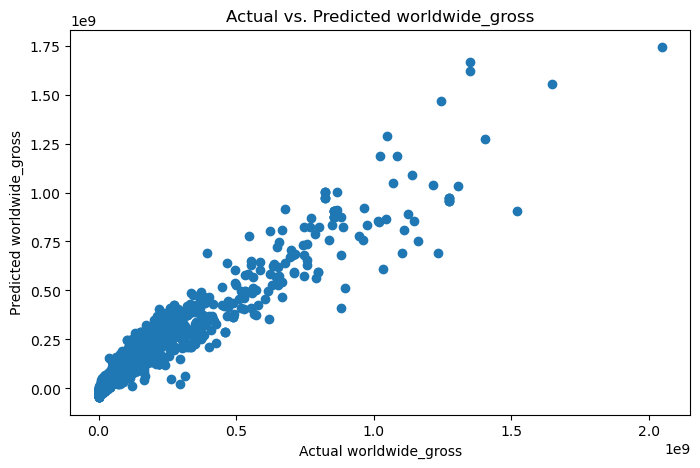

In [229]:
# 1. Linearity
# Plotting actual vs. predicted to check for linearity
plt.figure(figsize=(8, 5))
plt.scatter(y, model.predict(X))
plt.xlabel("Actual worldwide_gross")
plt.ylabel("Predicted worldwide_gross")
plt.title("Actual vs. Predicted worldwide_gross")
plt.show()

In [230]:
# 2. Independence of Errors (Durbin-Watson Test)
dw_test = durbin_watson(model.resid)
print(f'Durbin-Watson Test Statistic: {dw_test:.2f}')

Durbin-Watson Test Statistic: 1.31


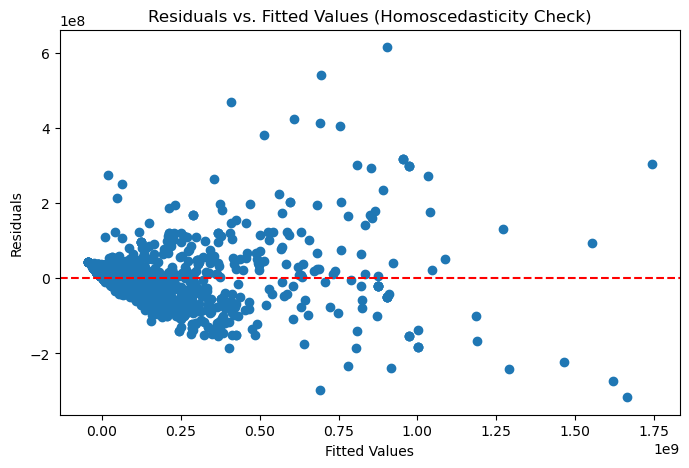

In [205]:
# 3. Homoscedasticity (Residuals vs. Fitted Values Plot) - Constant variance
plt.figure(figsize=(8, 5))
plt.scatter(model.predict(X), model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Homoscedasticity Check)")
plt.show()

<Figure size 800x500 with 0 Axes>

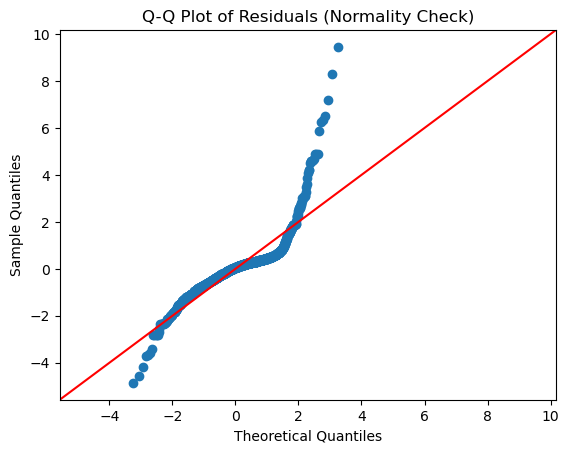

In [206]:
# 4. Normality of Errors (Q-Q plot and Shapiro-Wilk Test)
# Q-Q Plot
plt.figure(figsize=(8, 5))
sm.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.show()

In [207]:
# Shapiro-Wilk Test for normality of residuals
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk Test: W={shapiro_test[0]:.3f}, p-value={shapiro_test[1]:.3f}')

Shapiro-Wilk Test: W=0.800, p-value=0.000


In [208]:
# 5. Multicollinearity (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            Variable        VIF
0              const  34.238323
1         popularity   1.545269
2       vote_average   1.113848
3  production_budget   2.134383
4   domestic_gross_y   2.022219


In [209]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.05, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.6}')
        
        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude the intercept
        worst_pval = pvalues.max()  # highest p-value
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.6}')
        
        if not changed:
            break

    return included

# Define predictor variables and response variable
X = df[['popularity', 'vote_average', 'vote_count', 'production_budget', 'domestic_gross_y']]
y = df['roi']

# Perform stepwise selection
best_features = stepwise_selection(X, y)

# Fit the final model using the best features
X_best = sm.add_constant(X[best_features])
model = sm.OLS(y, X_best).fit()

print(model.summary())

Add  domestic_gross_y with p-value 6.03545e-08
Add  production_budget with p-value 1.3329e-29
Add  vote_average with p-value 0.0157636
                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     56.85
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           4.50e-35
Time:                        23:53:12   Log-Likelihood:                -6947.2
No. Observations:                1764   AIC:                         1.390e+04
Df Residuals:                    1760   BIC:                         1.392e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025  

In [210]:
conn.close()

In [211]:
# Delete the large file 

import os

# Specify the path to the file you want to delete
file_path = 'im.db'

# Check if the file exists before attempting to delete
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} does not exist.")

im.db does not exist.


# Data Visualizations

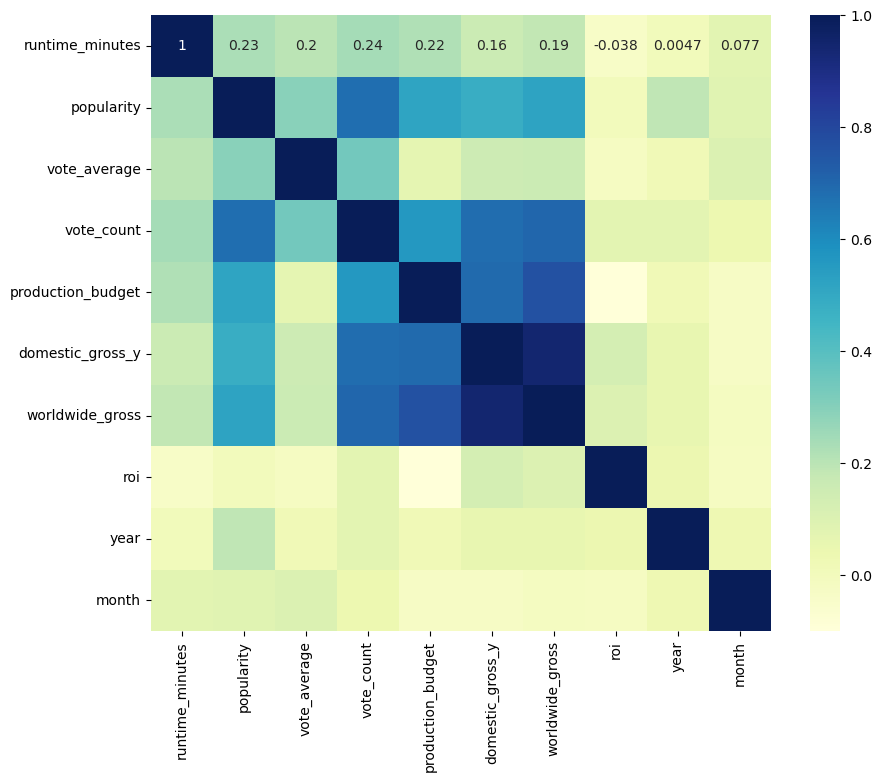

In [212]:
# Set figure size to make the plot larger
plt.figure(figsize=(10, 8))

# Plotting the correlation heatmap
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

# Displaying heatmap
plt.show()

Text(0.5, 1.0, 'ScatterPlot on Correlation')

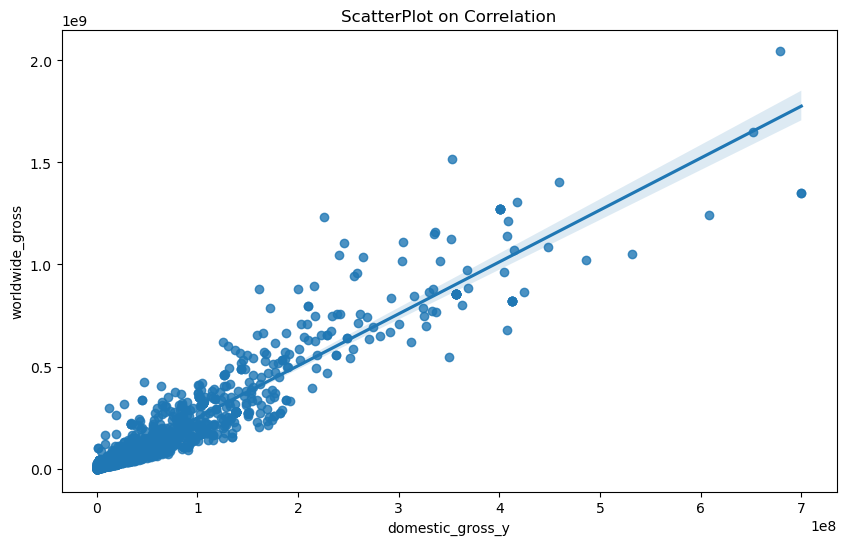

In [213]:
plt.figure(figsize = (10,6))

sns.regplot(data=df,x='domestic_gross_y',y='worldwide_gross')
plt.title('ScatterPlot on Correlation')

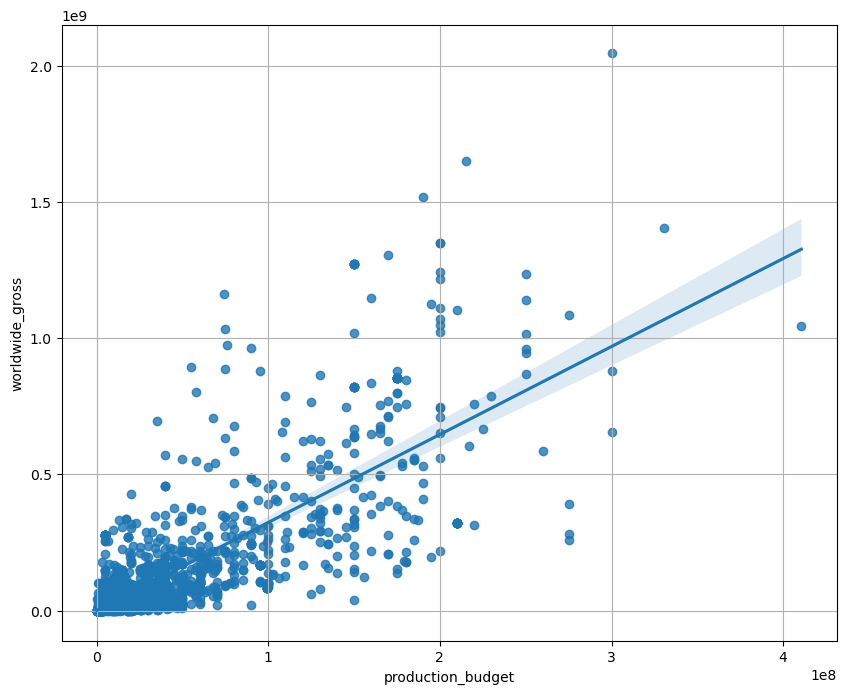

In [214]:
# Scatter plot for the budget against worlwide gross
plt.figure(figsize=(10,8))
sns.regplot(data=df,x='production_budget',y='worldwide_gross')
plt.grid()

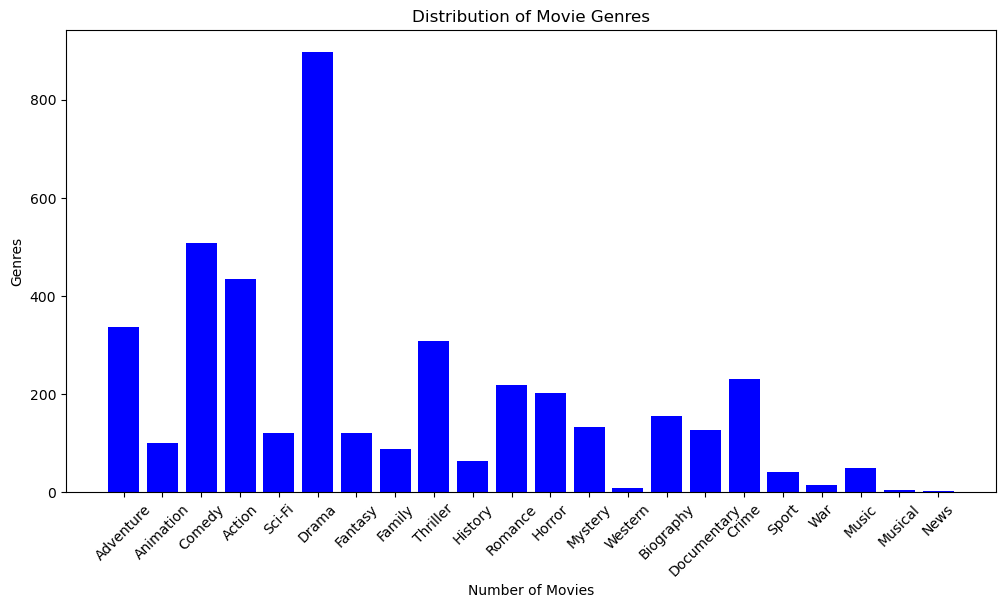

In [215]:
# Convert dictionary keys and values to lists for plotting
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Bar plot for genre counts
plt.figure(figsize=(12, 6))
plt.bar(genres, counts, color='blue')
plt.xlabel('Number of Movies')
plt.ylabel('Genres')
plt.title('Distribution of Movie Genres')
plt.xticks(rotation=45)
plt.show()

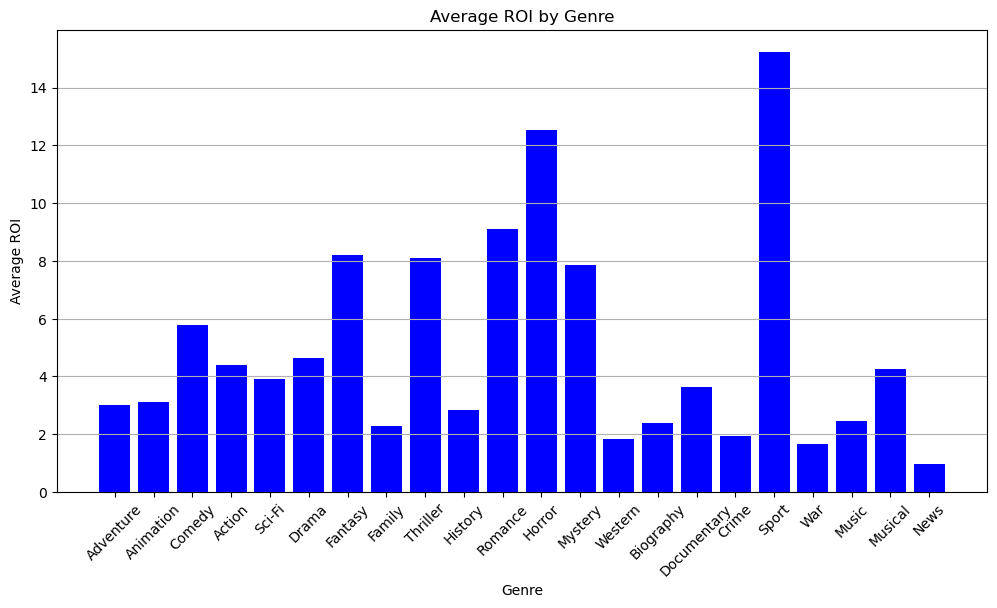

In [216]:
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(transposed_df['Genre'], transposed_df['gen_avg_roi'], color='blue')
plt.title('Average ROI by Genre')
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

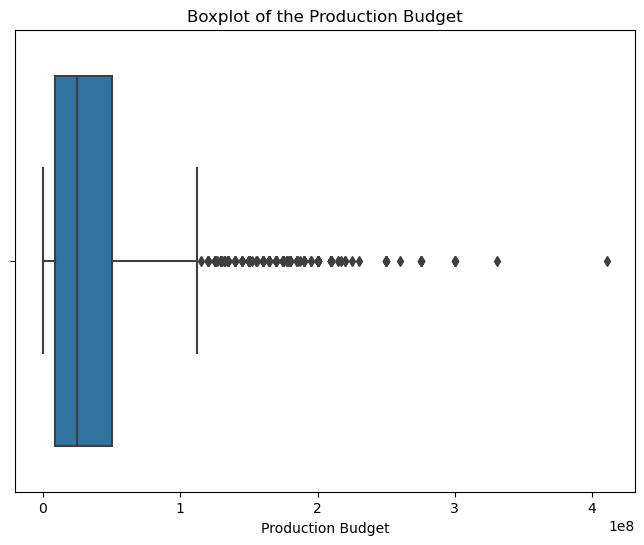

In [217]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='production_budget')
plt.xlabel('Production Budget')
plt.title('Boxplot of the Production Budget')
plt.show()

Text(0.5, 1.0, 'Distribution of the Runtime Minutes')

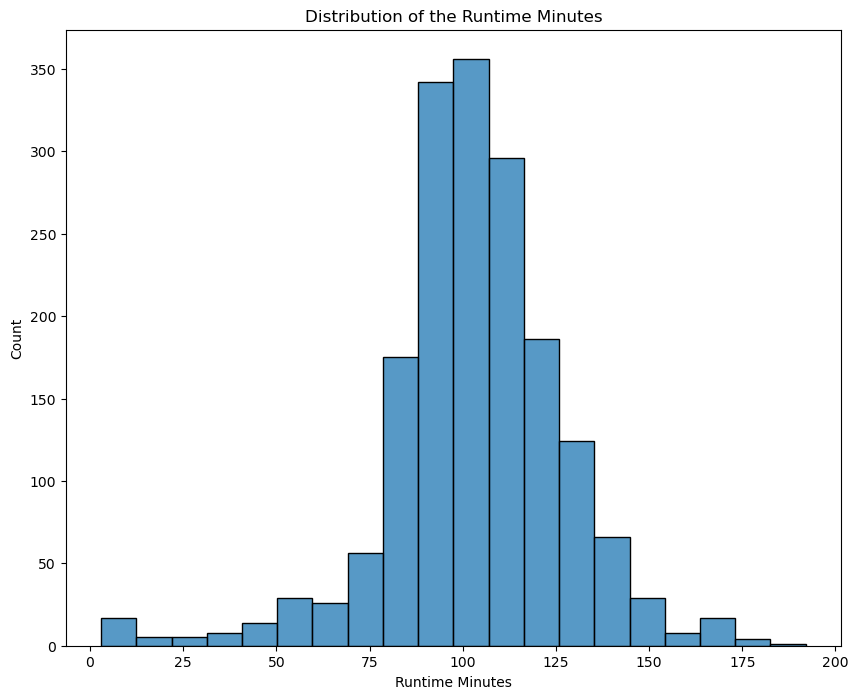

In [218]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='runtime_minutes',bins=20)
plt.xlabel('Runtime Minutes')
plt.title('Distribution of the Runtime Minutes')

Text(0.5, 1.0, 'Distribution of the Worldwide gross')

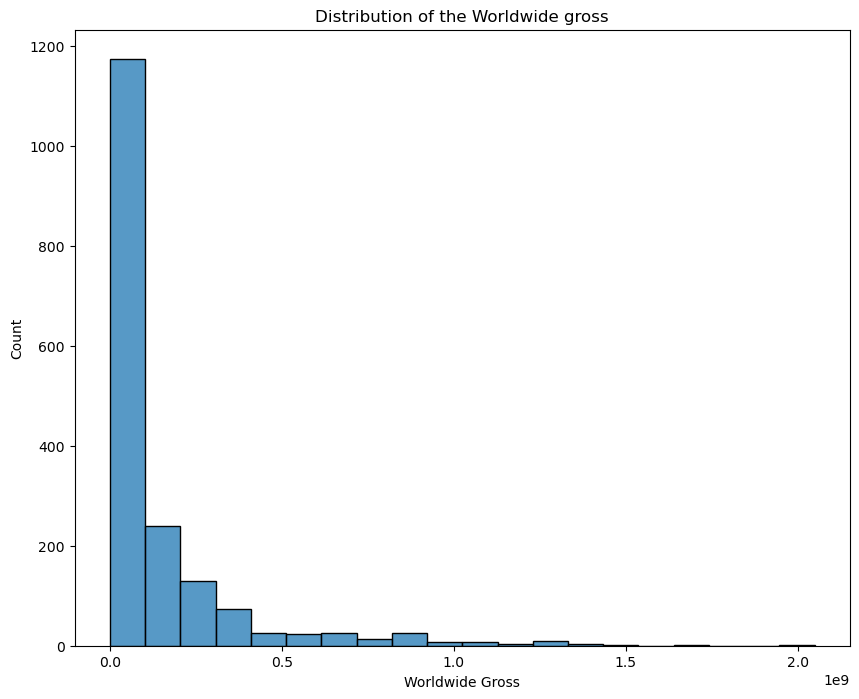

In [219]:
plt.figure(figsize=(10,8))
sns.histplot(data=df,x='worldwide_gross',bins=20)
plt.xlabel('Worldwide Gross')
plt.title('Distribution of the Worldwide gross')

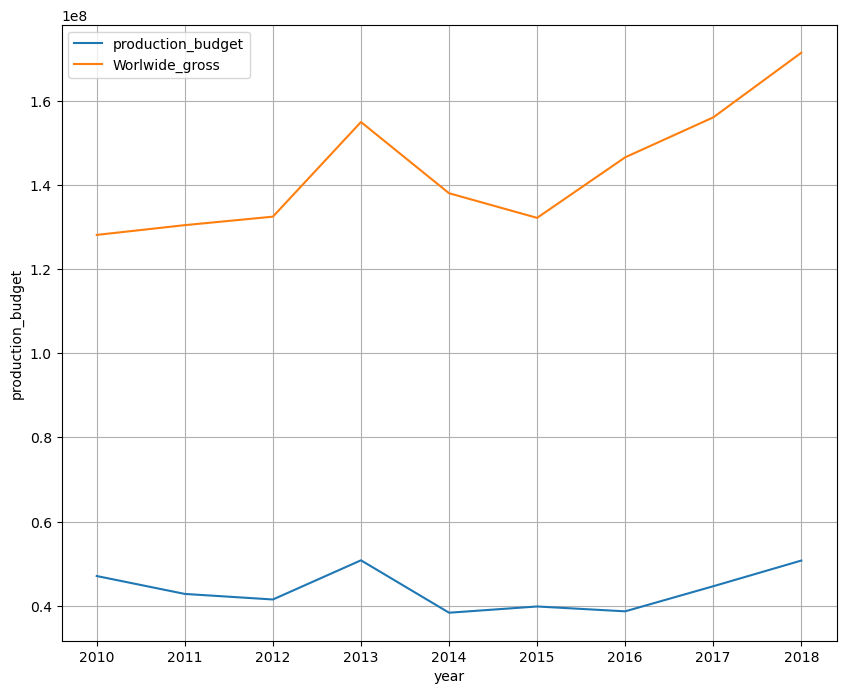

In [220]:
plt.figure(figsize=(10,8))
sns.lineplot(data=filter_data,x='year',y='production_budget',label='production_budget',ci=None)
sns.lineplot(data=filter_data,x='year',y='worldwide_gross',label='Worlwide_gross',ci=None)
# sns.lineplot()
plt.grid()

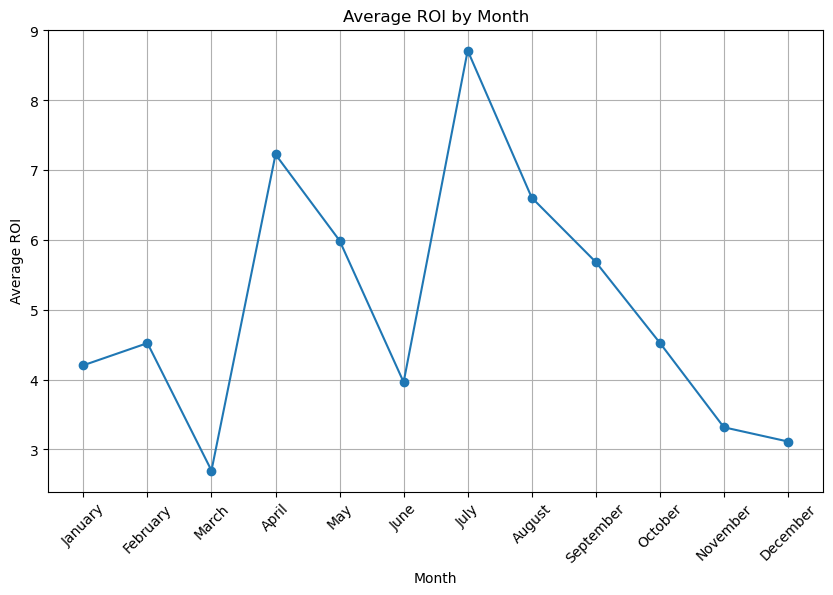

In [221]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(monthly_roi['month'], monthly_roi['roi'], marker='o')
plt.title('Average ROI by Month')
plt.xlabel('Month')
plt.ylabel('Average ROI')
plt.xticks(monthly_roi['month'], month_names[:len(monthly_roi)], rotation=45)  # Change numbers to month names
plt.grid()
plt.show()

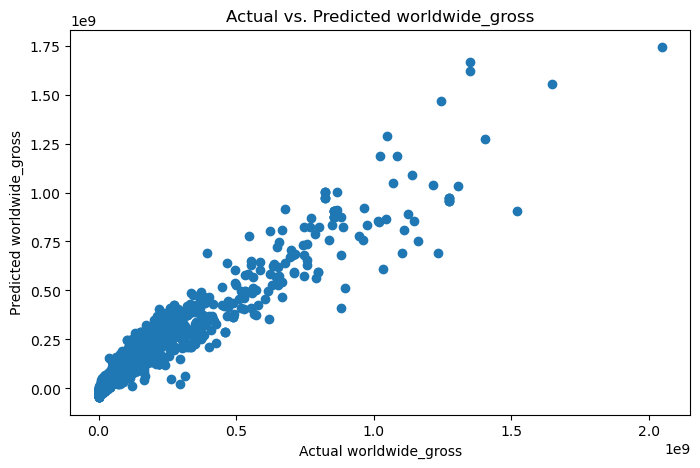

In [231]:
# 1. Linearity
# Plotting actual vs. predicted to check for linearity
plt.figure(figsize=(8, 5))
plt.scatter(y, model.predict(X))
plt.xlabel("Actual worldwide_gross")
plt.ylabel("Predicted worldwide_gross")
plt.title("Actual vs. Predicted worldwide_gross")
plt.show()

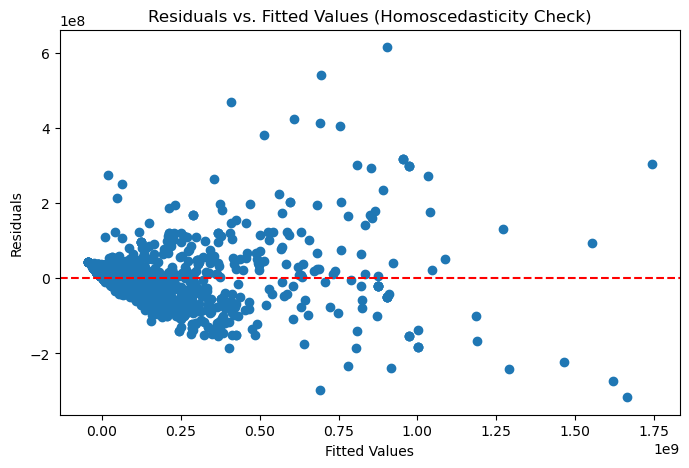

In [232]:
# 3. Homoscedasticity (Residuals vs. Fitted Values Plot) - Constant variance
plt.figure(figsize=(8, 5))
plt.scatter(model.predict(X), model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values (Homoscedasticity Check)")
plt.show()

<Figure size 800x500 with 0 Axes>

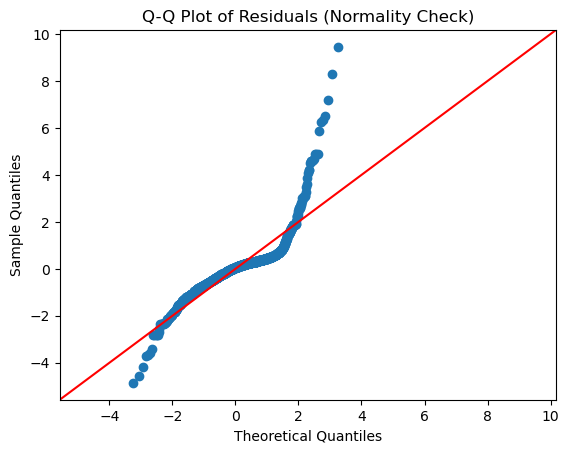

In [233]:
# 4. Normality of Errors (Q-Q plot and Shapiro-Wilk Test)
# Q-Q Plot
plt.figure(figsize=(8, 5))
sm.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Normality Check)")
plt.show()